In [12]:
## ライブラリの準備
import copy
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import random
import math
import pandas as pd
import copy
from IPython import display

## 壁を表す定数
WALL = 100000

around_list = [[1,0], [0,1], [-1,0], [0,-1], [1,1], [1,-1], [-1,-1], [-1,1]]
move_list = [[1,0], [0,1], [-1,0], [0,-1]]

# エージェントクラス

In [13]:
def remove_duplicates_keep_order(lst):
    seen = set()
    return [k for k in lst if not (k in seen or seen.add(k))]
    
class Agent():
    def __init__(self, ID, texts, init_x, init_y, true_goal_list, false_goal_list):
        self.id = ID
        self.current_loc = (init_x , init_y)
        self.path = []
        self.time = 0
        self.left_walk = 0
        self.finish = None
        self.careful = int(random.gauss(65, 10))
        self.careful = 100
        
        self.avoid = int(random.gauss(70, 10)) # 混雑回避パラメータ：これより小さい数値が与えられたときはCost_fieldを参照する。大きい数値なら無視して行動する。
        
        self.speed = 0
        while self.speed <= 1:
            self.speed = int(random.gauss(2, 1)) # random.gauss(平均値、標準偏差)→正規分布からランダムに値を取得
        self.now_speed = copy.deepcopy(self.speed)
        # self.speed = 1
        # 平均時速７km = 2 m/s （１マス=２０ cm）なので　【１０マス/s】
        
        self.listen = int(random.gauss(50, 10)) # 通行禁止アナウンスを聞いていたか判定する関数
        self.listen = 0
        if self.listen > random.randint(0, 100):
            self.know_false_list = false_goal_list
        else:
            self.know_false_list = []

        print('私のIDは' + str(self.id) + 'で、現在地は' + str(self.current_loc) + 'です。')

        self.changed_time = 0
        self.height = len(texts) # 高さを取得
        self.width = len(texts[0])  # 横幅を取得
        self.data = copy.deepcopy(maze_false_field) # 迷路データ（後に各個人で迷路の認識が異なる場合を作るためクラス内に設定）
        self.human_field = copy.deepcopy(maze_false_field) # 誰もいないときのfieldを取得
        self.Cost_field = copy.deepcopy(first_Cost_field)
        self.goal_list = []
        self.all_true_goal_list = true_goal_list

        for y in range(self.height):
            for x in range(self.width):
                if texts[y][x] == 'G':
                    self.goal_list.append((x, y))      # 取得データにゴール地点があれば記録
        self.init_x = copy.deepcopy(init_x)
        self.init_y = copy.deepcopy(init_y)
        self.x = init_x
        self.y = init_y
        self.start = (self.x, self.y)    # 各個人におけるスタート地点を記録
        
        # print(self.goal_list)
        self.hozon_list = copy.deepcopy(self.goal_list)
        
        self.goal_knows_list = []
        for i in range(int(len(self.goal_list)/2)):
            knows = 100
            self.goal_knows_list.append(knows)
            
        self.goal_knows_list = [100, 100, 100, 100, 100, 100]
        # print(self.goal_knows_list)
        
        OK = 0
        NO = 1
        while NO == 1:
            self.goal_list = copy.deepcopy(self.hozon_list)
            NO = 0
            for i in range(len(self.goal_knows_list)):
                self.not_knows = random.randint(0, 100)
                # print(self.not_knows)
                if self.goal_knows_list[i] < self.not_knows:
                    del self.goal_list[(i-OK)*2]
                    del self.goal_list[(i-OK)*2]
                    OK += 1
            if len(self.goal_list) == 0:
                NO = 1
                OK = 0
                
        # print('候補地')
        # print(self.goal_list)
        
        self.goal = (10000000, 10000000)
        for i in self.goal_list:
            if math.sqrt((self.start[0] - i[0]) ** 2 + (self.start[1] - i[1]) ** 2) < math.sqrt((self.start[0] - self.goal[0]) ** 2 + (self.start[1] - self.goal[1]) ** 2):
                self.goal = i
        

        print(self.start, self.goal, '速度：' + str(self.speed), '混雑回避P：' + str(self.avoid))
        
            
    def vision(self):
        # print(self.Cost_field)
        r = self.speed*2
        # r = 0
        R = self.speed*3
        # R = 0
        Y = self.start[1]
        X = self.start[0]
        careful = random.randint(0, 100)
        self.human_field = copy.deepcopy(maze_false_field) # 誰もいないときのfieldを取得
        self.Cost_field = copy.deepcopy(first_Cost_field)

        for i in agents:
            if X - r <= i.start[0] and i.start[0] <= X + r and Y- r <= i.start[1] and i.start[1] <= Y + r and careful <= i.careful:
            # 他のエージェントのリストを追加
                self.goal_list.append(i.goal)
                self.know_false_list.extend(i.know_false_list)

                # 重複を除去
                self.goal_list = remove_duplicates_keep_order(self.goal_list)
                self.know_false_list = remove_duplicates_keep_order(self.know_false_list)

                # 既知の偽目標を目標リストから除去
                self.goal_list = [j for j in self.goal_list if j not in self.know_false_list]

        for y in range(Y- R , Y + R + 1):
            for x in range(X - R, X + R + 1):
                if (0 <= x < self.width and 0 <= y < self.height):
                    self.data[y][x] = maze_field[y][x]
                    self.human_field[y][x] = next_human_field[y][x]
                    self.Cost_field[y][x] = next_Cost_field[y][x]

                    if self.data[y][x] == -100000 and maze_field[y][x] == WALL and (x,y) in self.goal_list:
                        self.goal_list.remove((x, y))
                        self.know_false_list.append((x, y))
    
    def change_now_speed(self):
        self.now_speed = copy.deepcopy(self.speed)
        # print(self.now_speed)
        Y = self.start[1]
        X = self.start[0]         
        self.count = 0
        for i in move_list:
            x = X + i[0]
            y = Y + i[1]
            if (0 <= x < self.width and 0 <= y < self.height):
                if self.human_field[y][x] > 0:
                    self.count += 1
        if self.count == len(move_list):
            self.now_speed = 0
            self.changed_time += 1
            # congection_field[Y][X] += 1
            # print('停止')
        elif self.count >= len(move_list) -2:
            self.now_speed = 1
            self.changed_time += 1

    ### Astarアルゴリズムの実行メソッド

    def astar(self):
        
        if len(self.goal_list) == 0:
            # print(len(self.all_true_goal_list))
            self.random_goal_number = random.randrange(0, len(self.all_true_goal_list), 2)
            self.goal_list.append(self.all_true_goal_list[self.random_goal_number])
            self.goal_list.append(self.all_true_goal_list[self.random_goal_number + 1])
            print(self.id, self.goal_list, self.random_goal_number)
        
        self.goal = (10000000, 10000000)
        # print(self.goal)
        # print(self.goal_list)
        for i in self.goal_list:
            if math.sqrt((self.start[0] - i[0]) ** 2 + (self.start[1] - i[1]) ** 2)< math.sqrt((self.start[0] - self.goal[0]) ** 2 + (self.start[1] - self.goal[1]) ** 2):
                self.goal = i
        # print(self.id, self.goal)
        
        ## 混雑度判断数
        avoidance = random.randint(0, 100)
        # avoidance = 0
        
        # print('ID：'+ str(self.id), '混雑回避確率：' + str(self.avoid), 'ランダムな値：' + str(avoidance))

        ## 調査し終えたどうか（および壁かどうか）を表すフィールド
        ## （未調査なら0，調査済みあるいは壁なら1以上）
        close_field = copy.deepcopy(self.data)
        
        ## スタートからの最短距離(関数G)をメモしていくフィールド
        G_field = [[WALL for x in range(self.width)] for y in range(self.height)]
        # print(G_field)

        ## A*アルゴリズムで使用する関数Fをメモしていくフィールド
        F_field = [[WALL for x in range(self.width)] for y in range(self.height)]
        # print(F_field)

        ## 調査予定の座標セット
        open_set = {self.start}

        # print(maze.start)

        ## スタート地点のG値をゼロに，F値をG+Hに設定する
        G_field[self.start[1]][self.start[0]] = 0
        F_field[self.start[1]][self.start[0]] = math.sqrt((self.start[0] - self.goal[0]) ** 2 + (self.start[1] - self.goal[1]) ** 2)


        """ダイクストラ法①"""
        # F_field[maze.start[1]][maze.start[0]] = 0

        focal = None    ## 調査中の座標を表す変数
        # trial = 0       ## 試行回数のカウンタ

        ## 調査予定の座標がなくなるまで繰り返す
        while len(open_set) > 0:

            # trial += 1      ## 試行回数を増加
            open_list = [i for i in open_set]
            random.shuffle(open_list)
            # print(open_list)

            ## 調査予定の座標セットから，最もFの値が小さいものを見つけてfocalにセットする
            F_min = WALL
            for x, y in open_list:
                if F_field[y][x] < F_min:
                    focal = (x, y)
                    F_min = F_field[y][x]
            # print(focal, F_min)

            ## focalにセットした座標は調査予定群から取り除き，調査済みとする
            # print(focal)
            open_set.remove(focal)
            open_list.remove(focal)
            close_field[focal[1]][focal[0]] = 1
            # print(open_set)

            ## もしfocalがゴール地点であれば，探索は終了する
            if focal[0] == self.goal[0] and focal[1] == self.goal[1]:
                break

            ## focalから上下左右の操作で移動可能な座標を順番に見ていく
            for x, y in move_list:

                ## 移動後の座標をneighborと呼ぶ
                neighbor = (focal[0]+x, focal[1]+y)

                # print(neighbor)
                
                # print(close_field[neighbor[1]][neighbor[0]])
                
                ## もしneighborが調査済みあるいは壁なら，移動不可能なので次へ
                if close_field[neighbor[1]][neighbor[0]] > 0:
                    # print('SKIP')
                    continue


                # print(Cost_field[neighbor[1]][neighbor[0]])
                
                ## 混雑度認識判定
                if self.avoid >= avoidance:
                    ## Cost_fieldを参照して経路探索を行う
                    G = G_field[focal[1]][focal[0]] + self.Cost_field[neighbor[1]][neighbor[0]]
                    # print(G)
                    # print('avoid!')
                
                else:
                    ## neighborにおける最短距離Gをfocalの最短距離+1で更新（Cost_fieldを参照しない）
                    G = G_field[focal[1]][focal[0]] + 1
                    # print('Dont avoid')
                    # print(G)
                    
                ## neighborにおけるHの値を計算
                H = math.sqrt((neighbor[0] - self.goal[0]) ** 2 + (neighbor[1] - self.goal[1]) ** 2)
                # print(H)
                
                
                """ダイクストラ法②"""
                # H = 0
                
                
                ## もし今計算したF=G+Hの値が，事前にメモされていたFの値より小さければ更新
                if F_field[neighbor[1]][neighbor[0]] > G + H:
                    G_field[neighbor[1]][neighbor[0]] = G
                    F_field[neighbor[1]][neighbor[0]] = G + H
                    # print(F_field[neighbor[1]][neighbor[0]])

                ## 調査予定セットにneighborを加える（セットなので既に存在していたら変化なし）
                open_set.add(neighbor)

        ## ゴール地点を見つけられないまま繰り返しが終了した場合
        else:
            print( "ID:" + str(self.id) + " " + str(self.goal) + "までの経路が見つかりません")
            self.goal_list.remove(self.goal)
            self.know_false_list.append(self.goal)
            self.know_false_list = list(dict.fromkeys(self.know_false_list))
            print(self.goal_list)
            return

        ## スタート地点からゴール地点までの最短経路をゴール地点から遡って求める
        path = [self.goal]
        
        ## 上記の繰り返しを抜けた段階ではfocalがゴール地点を指している．そこから
        ## スタート地点に至るまで一歩ずつ戻っていく
        while not(focal[0] == self.start[0] and focal[1] == self.start[1]):
            
            # print(focal)
            # print('a')

            ## 移動可能地点を全て探索
            for x, y in move_list:
                neighbor = (focal[0]+x, focal[1]+y)  ## 移動後座標をneighborと呼ぶ
                

                ## もしneighborのGの値がfocalのGの値よりfocalの座標におけるコスト分だけ小さかったら，
                ## neighborは最短経路に含まれるのでfocalを更新．forループを抜ける
                if self.avoid >= avoidance:
                    if G_field[focal[1]][focal[0]] - G_field[neighbor[1]][neighbor[0]] == self.Cost_field[focal[1]][focal[0]]:
                        path.append(neighbor)
                        focal = neighbor
                        break
                else:
                    if G_field[focal[1]][focal[0]] - G_field[neighbor[1]][neighbor[0]] == 1:
                        path.append(neighbor)
                        focal = neighbor
                        break
                
                
        # print(trial)         ## 調査した回数を表示
        
        self.path = path[::-1]
        # print('ID：' + str(self.id), '　予定経路：' + str(self.path))    ## 経路を表示（ゴール→スタートの順になっているので逆順にする必要あり）

        
    def walk(self):
    
        self.one_feet = copy.deepcopy(1) # 現時間での歩行速度
        self.next_point = copy.deepcopy(self.path[1]) # 現時間歩行速度における次の移動座標
        if human_field[self.next_point[1]][self.next_point[0]] == 0 and next_human_field[self.next_point[1]][self.next_point[0]] == 0: # もし次移動する座標の現時間に人がいないなら
            # 現在地から移動して
            next_human_field[self.start[1]][self.start[0]] -= self.id
            if self.start != (self.init_x, self.init_y):
                next_Cost_field[self.before_start[1]][self.before_start[0]] -= 4
            # 新しい位置を記録
            next_human_field[self.next_point[1]][self.next_point[0]] += self.id
            next_Cost_field[self.next_point[1]][self.next_point[0]] += 4
            self.before_start = copy.deepcopy(self.start)
            self.start = copy.deepcopy(self.next_point)
            
        # # もし人がいるなら、停止したことを記録してその間動けなくする
        else:
            congection_field[self.start[1]][self.start[0]] += 1
            self.now_speed = 0
            
    def complete_walk(self):
        # print(next_human_field)
        next_human_field[self.start[1]][self.start[0]] -= self.id 
        next_Cost_field[self.start[1]][self.start[0]] -= 4
        if self.start != (self.init_x, self.init_y):
            next_Cost_field[self.before_start[1]][self.before_start[0]] -= 4
        
        # print('ID:' + str(self.id) + '移動時間：' + str(self.time) + '秒で移動完了です。余力歩行可能数：' + str(self.left_walk) + 'マス' )

# 迷路データの取得

In [14]:
maze_data = pd.read_csv('kannimeiro_huge.csv',header=None).values.tolist()
maze_false_data = pd.read_csv('kannimeiro_huge_false.csv',header=None).values.tolist()
# print(maze_data)


In [15]:
# 全エージェントが共通して持つ移動コスト（まっさらなとき）
Cost_field = [[1 for x in range(len(maze_data[y]))] for y in range(len(maze_data))]
human_field = [[0 for x in range(len(maze_false_data[y]))] for y in range(len(maze_false_data))]
maze_field = [[0 for x in range(len(maze_data[y]))] for y in range(len(maze_data))]
maze_false_field =  [[0 for x in range(len(maze_false_data[y]))] for y in range(len(maze_false_data))]
true_goal_list = []
false_goal_list =[]

for y in range(len(maze_data)):
    for x in range(len(maze_data[y])):
        if maze_data[y][x] == 'x':
            maze_field[y][x] = WALL ## 壁だったらWALLに変換
        if maze_data[y][x] == 'G':
            maze_field[y][x] = -100000
            true_goal_list.append((x, y))

for y in range(len(maze_false_data)):
    for x in range(len(maze_false_data[y])):
        if maze_false_data[y][x] == 'x':
            human_field[y][x] = WALL ## 壁だったらWALLに変換
            maze_false_field[y][x] = WALL ## 壁だったらWALLに変換
            Cost_field[y][x] = WALL ## 壁だったらWALLに変換
        if maze_false_data[y][x] == 'G':
            human_field[y][x] = -100000
            maze_false_field[y][x] = -100000
            false_goal_list.append((x, y))

for i in true_goal_list:
    false_goal_list.remove(i)
print(false_goal_list)
            
first_Cost_field = copy.deepcopy(Cost_field) # 誰もいないときのコストフィールド
congection_field = copy.deepcopy(maze_false_field) # エージェントが停止した位置を記録するフィールド

[(59, 35), (60, 35), (64, 35), (65, 35)]


# 初期位置の設定、インスタンス化

In [16]:
agent_num = 10
agents = []
agents_dict = {}

for i in range(agent_num):
    ok = 0
    while ok == 0: # 人がいるときの移動コストの設定
        init_y = random.randint(0,len(maze_field)-1)
        init_x = random.randint(0,len(maze_field[0])-1)
        if human_field[init_y][init_x] == 0 and maze_field[init_y][init_x] == 0: 
            ok = 1
    agent = Agent(i+1, maze_false_data, init_x, init_y, true_goal_list, false_goal_list)
    agents.append(agent)
    agents_dict[i+1] = agent
    Cost_field[init_y][init_x] += 4
    human_field[init_y][init_x] = i+1

# print(agents_dict)
next_human_field = copy.deepcopy(human_field)
next_Cost_field = copy.deepcopy(Cost_field)
# print(human_field)
# plot_maze(human_field)

私のIDは1で、現在地は(8, 5)です。
(8, 5) (14, 28) 速度：3 混雑回避P：69
私のIDは2で、現在地は(38, 31)です。
(38, 31) (54, 45) 速度：2 混雑回避P：62
私のIDは3で、現在地は(64, 42)です。
(64, 42) (64, 35) 速度：2 混雑回避P：65
私のIDは4で、現在地は(105, 17)です。
(105, 17) (105, 26) 速度：2 混雑回避P：72
私のIDは5で、現在地は(118, 35)です。
(118, 35) (105, 27) 速度：2 混雑回避P：84
私のIDは6で、現在地は(112, 44)です。
(112, 44) (105, 27) 速度：2 混雑回避P：59
私のIDは7で、現在地は(52, 33)です。
(52, 33) (59, 35) 速度：2 混雑回避P：66
私のIDは8で、現在地は(103, 39)です。
(103, 39) (105, 27) 速度：2 混雑回避P：70
私のIDは9で、現在地は(74, 29)です。
(74, 29) (65, 35) 速度：3 混雑回避P：76
私のIDは10で、現在地は(118, 32)です。
(118, 32) (105, 27) 速度：2 混雑回避P：71


# アニメーションの描画設定

In [17]:
def plot_maze(field, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    else:
        fig = ax.get_figure()
    
    ax.axis('off')
    ax.set_aspect('equal')
    im = ax.imshow(field, cmap='Greys')

    # マップの行数と列数を取得
    num_rows, num_cols = np.array(field).shape

    # 図のサイズ（インチ）とDPIを取得
    fig_size = fig.get_size_inches()
    fig_dpi = fig.dpi

    # 図のサイズをピクセル単位に変換
    pixel_size = fig_size * fig.dpi

    # 一マスあたりのピクセルサイズを計算
    side_length = min(pixel_size[0] / num_cols, pixel_size[1] / num_rows)
    marker_area = side_length**2
    
    sc_st_list = []
    tx_st_list = []

    # 以下、エージェントの描画...
    for i in agents:
        
        if i.goal in false_goal_list:
            sc_st = ax.scatter([i.start[0]], [i.start[1]], c='y', s = marker_area/2, marker = ",")
            sc_st_list.append(sc_st)
            tx_st = ax.text(i.start[0], i.start[1], i.id, ha='center', va = 'center', fontsize=7, c='w', weight='bold')
            tx_st_list.append(tx_st)
        else:
            sc_st = ax.scatter([i.start[0]], [i.start[1]], c='b', s = marker_area/2, marker = ",")
            sc_st_list.append(sc_st)
            tx_st = ax.text(i.start[0], i.start[1], i.id, ha='center', va = 'center', fontsize=7, c='w', weight='bold')
            tx_st_list.append(tx_st)
            
    sc_go_list = []
    tx_go_list = []
    for g in true_goal_list:
        sc_go = ax.scatter([g[0]],[g[1]],c='r', s = marker_area/2, marker = ",")
        sc_go_list.append(sc_go)
        tx_go = ax.text(g[0], g[1],'G',ha='center', va = 'center', fontsize=7, c='w', weight='bold')
        tx_go_list.append(tx_go)
    
    maze = [im]
    for i in range(len(sc_st_list)):
        
        maze += [sc_st_list[i]]
        maze += [tx_st_list[i]]
        
    for i in range(len(sc_go_list)):
        
        maze += [sc_go_list[i]]
        maze += [tx_go_list[i]]
                
    return maze

# 初期迷路の描画

 Text(8, 5, '1'),
 Text(38, 31, '2'),
 Text(64, 42, '3'),
 Text(105, 17, '4'),
 Text(118, 35, '5'),
 Text(112, 44, '6'),
 Text(52, 33, '7'),
 Text(103, 39, '8'),
 Text(74, 29, '9'),
 Text(118, 32, '10'),
 Text(72, 1, 'G'),
 Text(73, 1, 'G'),
 Text(105, 26, 'G'),
 Text(105, 27, 'G'),
 Text(14, 28, 'G'),
 Text(15, 28, 'G'),
 Text(54, 45, 'G'),
 Text(55, 45, 'G')]

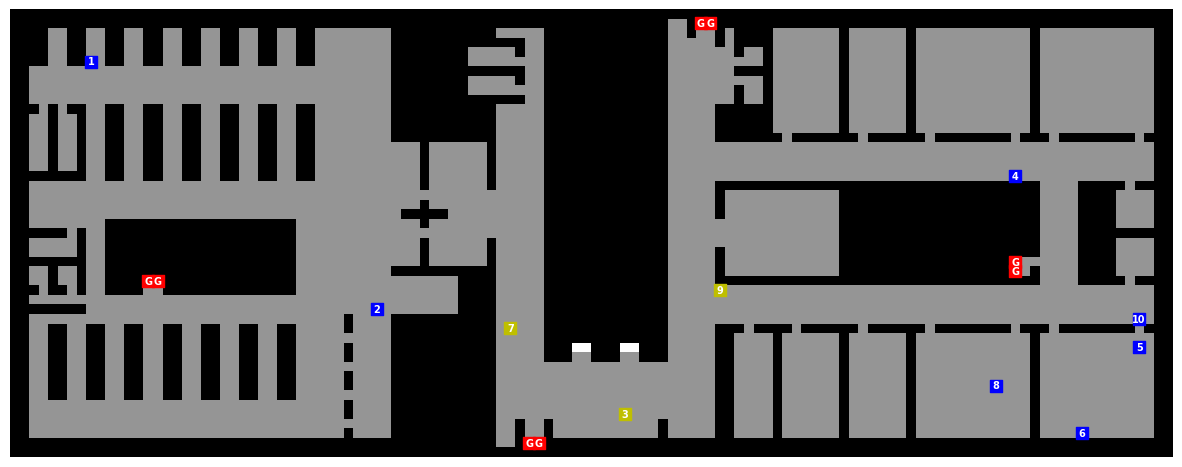

In [18]:
# plot_maze(maze_field)
plot_maze(human_field)
# plot_maze(maze_false_field)

# Astarアルゴリズムの実行

In [19]:
# for i in agents:
#     i.vision()
#     i.astar()

## エージェントを速度ごとに歩かせる。

0
ID:9 (65, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (59, 35), (60, 35), (64, 35), (54, 45), (55, 45)]
ID:3 (64, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (59, 35), (60, 35), (65, 35), (54, 45), (55, 45)]
ID:3 (65, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (59, 35), (60, 35), (54, 45), (55, 45)]
1
ID:3 (60, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (59, 35), (54, 45), (55, 45)]
ID:3 (59, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (54, 45), (55, 45)]
ID:9 (64, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (59, 35), (60, 35), (54, 45), (55, 45)]
2
ID:7 (59, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (60, 35), (64, 35), (65, 35), (54, 45), (55, 45)]
3
ID:7 (60, 35)までの経路が見つかりません
[(72, 1), (73, 1), (105, 26), (105, 27), (14, 28), (15, 28), (64, 35)

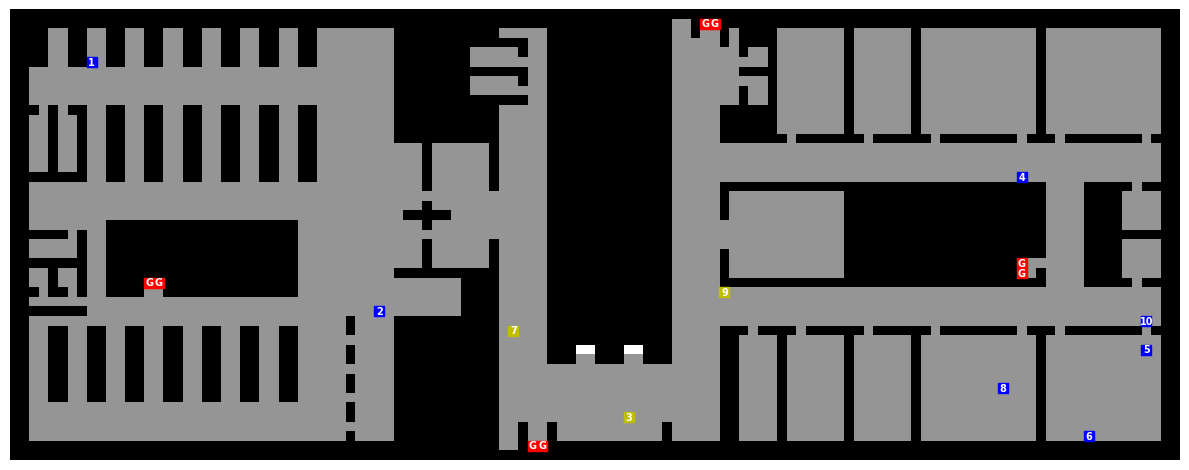

In [20]:
complete = 0
goal_list = []
ims = []
changed_time_list = []
ax = None
if ax is None:
    fig, ax = plt.subplots(figsize=(12, 5),tight_layout=True)
t = 0
max_speed = 0

ims.append(plot_maze(human_field, ax=ax)) 
while complete != agent_num: # 一秒ごとのループ
    goal_list = []
    max_speed = 0
    print(t)
    random.shuffle(agents)
    for n in agents:
        n.vision()
        n.change_now_speed()
        if max_speed < n.now_speed:
            max_speed = copy.deepcopy(n.now_speed)
    
    # print(max_speed)
    for i in range(max_speed): # 歩数のループ
        for j in reversed(agents): # 一歩ずつ各エージェントを歩かせる
            j.vision()
            if i+1 <= j.now_speed:
                j.astar()
                if len(j.path) > 2:
                    j.walk()
                elif len(j.path) > 0:
                    j.complete_walk()
                    
                    complete += 1
                    agents.remove(j)
                    agents_dict.pop(j.id)
                    changed_time_list.append(j.changed_time)
                    print('ゴール済み' + str(complete))
            # else:
            #     print(j.now_speed)
    human_field = copy.deepcopy(next_human_field)
    Cost_field = copy.deepcopy(next_Cost_field)
    t += 1

    # ims.append(plot_maze(human_field, ax=ax)) # ここが重い！！！！！！！！！！！！

print('総移動時間：' + str(t) + '秒')
# ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=1000)
# ani.save('Astar_animation.gif', writer = 'pillow')
# ## アニメーションをHTML形式にして表示
# html = display.HTML(ani.to_jshtml())
# display.display(html)
# plt.close()

# ヒートマップの作製

In [21]:
# 先に黒一色で描画し、後から壁を除いた部分を虹色グラデーション（通路は白色）で描画する

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

print('速度変化合計時間：' + str(sum(changed_time_list)))
print(max(changed_time_list))

denger_num = 50

flat_list = set([item for sublist in congection_field for item in sublist])
# リストをソートする
sorted_list = sorted(flat_list, reverse=True)
# 二番目に大きい値を取得する
second_largest = sorted_list[1]
print('ヒートマップ最大値：' + str(second_largest))

heatmap_count = 0
for y in range(len(congection_field)):
    for x in range(len(congection_field[y])):
        if congection_field[y][x] >= denger_num and congection_field[y][x] < WALL:
            heatmap_count += 1
print('危険区域の面積：' + str(heatmap_count))

data = congection_field
np_data = np.array([[100000 if x == -100000 else x for x in row] for row in data])
transformed_data = np.where(np_data >= 100000, 100000, np_data)

# 壁のためのマスク作成
wall_mask = np_data == 100000

# 全て黒色のカラーマップ作成
black_cmap = ListedColormap(['black'])

# ヒートマップの描画（全て黒一色）
plt.figure(figsize=(15, 6))
sns.heatmap(np_data, cmap=black_cmap, cbar=False)

# 虹色カラーマップの作成（通路は白色）
cmap_rainbow = plt.cm.get_cmap('rainbow', 256)
rainbow_colors = cmap_rainbow(np.linspace(0, 1, 256))
rainbow_colors[0] = [1, 1, 1, 1]  # 白（通路）

# カスタムカラーマップ
custom_cmap = LinearSegmentedColormap.from_list('custom_rainbow', rainbow_colors, N=256)

# 虹色グラデーションのヒートマップの描画（壁を除く）
sns.heatmap(transformed_data, cmap=custom_cmap, vmax=denger_num, vmin=0, mask=wall_mask)

plt.show()
plt.close()


ModuleNotFoundError: No module named 'seaborn'

In [ ]:
print(congection_field)

NameError: name 'congection_field' is not defined